# FicEmbed Training Run on Romeo and Juliet

## Installs and Imports

In [1]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses
!pip install transformers
!pip install torch

In [14]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from sklearn.manifold import TSNE
import plotly.express as px
import pickle

In [15]:
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch_device

'cuda'

## Network Architecture

In [16]:
class GraphConvolution(torch.nn.Module):
    def __init__(self, character_embedding_dim, edge_dim):
        super(GraphConvolution, self).__init__()

        self.ce_dim = character_embedding_dim
        self.e_dim = edge_dim

        self.activation = nn.Sigmoid()
        
        self.message_to_listener = nn.Sequential(nn.Linear(character_embedding_dim + edge_dim, character_embedding_dim),
                                                self.activation)
        
        self.message_to_speaker = nn.Sequential(nn.Linear(character_embedding_dim + edge_dim, character_embedding_dim),
                                                self.activation)
        
        self.listener_update = nn.Sequential(nn.Linear(character_embedding_dim, character_embedding_dim), self.activation)
        self.speaker_update = nn.Sequential(nn.Linear(character_embedding_dim, character_embedding_dim), self.activation)

    def forward(self, character_embeddings, dialogue_embeddings, speakers, listeners):
        '''
          -> (speakers intersect listeners) should be an empty set!
        '''

        character_embeddings = character_embeddings.detach()

        speaker_features = character_embeddings[speakers, :]
        listener_features = character_embeddings[listeners, :]

        speaker_listener_dialogue =  torch.cat((speaker_features - listener_features, dialogue_embeddings), dim=-1)

        # Residual connection included to avoid dying gradients
        updated_speakers = self.speaker_update(speaker_features + self.message_to_listener(speaker_listener_dialogue)) + speaker_features 
        updated_listeners = self.listener_update(listener_features + self.message_to_speaker(speaker_listener_dialogue)) + listener_features 

        out = character_embeddings.clone()
        out[speakers, :] = updated_speakers
        out[listeners, :] = updated_listeners

        return out

class GCLWithHeadBert(torch.nn.Module):
  def __init__(self, character_embedding_dim, bert_dim, edge_dim, out_dim):
    super(GCLWithHeadBert, self).__init__()

    self.bert_dim = bert_dim
    # Maps 2 * character_embedding_dim to out_dim
    # Add a Transformer layer as head + edge_translator
    self.head = nn.Sequential(nn.Linear(2 * character_embedding_dim, out_dim),
                                nn.ReLU(),
                                nn.Linear(out_dim, out_dim))
    self.edge_translator = nn.Linear(bert_dim, edge_dim)
    self.gcn_layer = GraphConvolution(character_embedding_dim, edge_dim)
    self.activation = nn.Sigmoid()

  def forward(self, character_embeddings, embedding, speaker, listener):
    edge_feature = self.activation(self.edge_translator(embedding.detach())[None, :])
    updated_embeddings = self.gcn_layer(character_embeddings, edge_feature, speaker, listener)
    linear_layer_out = self.activation(self.head(torch.cat((updated_embeddings[speaker, :], updated_embeddings[listener, :]), axis=1)))
    return updated_embeddings, linear_layer_out

## Data Import and Wrangling

In [17]:
df_dialogs = pd.read_csv('rj_vadr_bert.csv').drop(columns=["Unnamed: 0"])
character_enum = pd.DataFrame(df_dialogs["speaker"].unique()).reset_index().rename(columns={0:'character'})
df_dialogs_with_speaker_enumeration = pd.merge(left=df_dialogs,
                                       right=character_enum,
                                       left_on="speaker",
                                       right_on="character",
                                       how="left").rename(columns={'index': 'speaker_index'}).drop(columns=['character'])
df_dialogs_with_listener_enumeration = pd.merge(left=df_dialogs_with_speaker_enumeration,
                                       right=character_enum,
                                       left_on="listener",
                                       right_on="character",
                                       how="left").rename(columns={'index': 'listener_index'}).drop(columns=['character'])
data_d = df_dialogs_with_listener_enumeration[['speaker', 'listener', 'speaker_index', 'listener_index', 'dialogue', 'dialogue_sentiment', 'avg_sentiment', 'bert']]
data = data_d.T.drop_duplicates().T
data

,speaker,listener,speaker_index,listener_index,dialogue,dialogue_sentiment,avg_sentiment,bert
0,CHORUS,SAMPSON,0,1,"Two households, both alike in dignity, In fair...",-0.5719,-0.5719,"[-0.062187887728214264, 0.04341184347867966, 0..."
1,SAMPSON,CHORUS,1,0,"Gregory, on my word, we’ll not carry coals.",0.0,0.0,"[-0.14115169644355774, 0.5629909634590149, -0...."
2,SAMPSON,GREGORY,1,2,"Gregory, on my word, we’ll not carry coals.",0.0,-0.062038,"[-0.14115169644355774, 0.5629909634590149, -0...."
3,GREGORY,SAMPSON,2,1,"No, for then we should be colliers.",0.0,-0.087993,"[-0.1291680932044983, 0.28564387559890747, -0...."
4,GREGORY,SAMPSON,2,1,"No, for then we should be colliers.",0.0,-0.087993,"[-0.1291680932044983, 0.28564387559890747, -0...."
...,...,...,...,...,...,...,...,...
1681,MONTAGUE,CAPULET,9,7,"But I can give thee more, For I will raise her...",0.6956,0.2643,"[-0.30834853649139404, -0.08796899765729904, -..."
1682,MONTAGUE,CAPULET,9,7,"But I can give thee more, For I will raise her...",0.6956,0.2643,"[-0.30834853649139404, -0.08796899765729904, -..."
1683,CAPULET,MONTAGUE,7,9,"As rich shall Romeo’s by his lady’s lie, Poor ...",0.128,-0.127267,"[-0.21812646090984344, 0.143050417304039, -0.1..."
1684,CAPULET,PRINCE,7,11,"As rich shall Romeo’s by his lady’s lie, Poor ...",0.128,0.062967,"[-0.21812646090984344, 0.143050417304039, -0.1..."


In [18]:
train_data = data.iloc[:int(0.6*len(data))]
valid_data = data.iloc[int(0.6*len(data)):int(0.8*len(data))]
test_data = data.iloc[int(0.8*len(data)):]
print(f"Sizes: train {len(train_data)}, valid {len(valid_data)}, test {len(test_data)}")

Sizes: train 1011, valid 337, test 338


In [19]:
# Ground truth labels are given by datapoint['dialogue_sentiment']
# Smooth out the labels, moving them away from extreme values like 0, 1 and -1. You may use datapoint['avg_sentiment'] to do this.

def smooth_labels(labels, smooth_factor=0.1):
    labels *= (1 - smooth_factor)
    labels += smooth_factor / labels.shape[0]
    return labels

for dataset in [train_data, valid_data, test_data]:
    dataset['smoothed_dialogue_sentiment'] = smooth_labels(dataset['dialogue_sentiment'].values)

/home/amks/ficembed/env/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


## Training

Note: With the values of hyperparameters, as given, training takes ~20 minutes!

In [20]:
# Data extraction functions 
def get_ground_truth(datapoint, smoothed=True):
    if smoothed:
        return datapoint['smoothed_dialogue_sentiment']
    else:
        return datapoint['dialogue_sentiment']

def get_bert_embedding(datapoint):
    return datapoint['bert']

def get_speaker(datapoint):
    return datapoint['speaker_index']

def get_listener(datapoint):
    return datapoint['listener_index']

def get_dialogue(datapoint):
    return datapoint['dialogue']

In [21]:
def run_validation(model, criterion, character_embeddings, valid_data, hyperparameters):
    """
    Returns average validation loss for a given model and validation dataset.
    """
    val_losses = []
    for index, row in valid_data.iterrows():
        dialog_gt = get_ground_truth(row, smoothed=hyperparameters['smooth_labels'])
        y = torch.tensor(dialog_gt).view(-1, 1).to(torch_device) 

        # Fetch embeddings
        bert_val = get_bert_embedding(row)
        bert_row = np.array([float(val) for val in bert_val.strip('][').split(', ')])
        bert_embed = torch.from_numpy(bert_row).float().to(torch_device)

        # Fetch speaker and listener
        speaker = torch.tensor([row['speaker_index']]).to(torch_device)
        listener = torch.tensor([row['listener_index']]).to(torch_device)

        with torch.no_grad():
            _, output = model(character_embeddings, bert_embed, speaker, listener)
        loss = criterion(output, y)
        val_losses.append(loss.item())

    return np.mean(val_losses)

In [27]:
def train_loop(model, optimizer, criterion, scheduler, character_embeddings, train_data, valid_data, hyperparameters, print_every = 1000):
  # Character embeddings are randomly initialized
  torch.autograd.set_detect_anomaly(True)
  losses = {}
  all_losses = []
  val_losses = []

  print('Running training dialogues:', len(train_data))
  epochs = hyperparameters['epochs']
  iters_per_dialog = hyperparameters['iters_per_dialog']
  for epoch in range(epochs):
    for index, row in tqdm.tqdm(train_data.iterrows()):
      for j in range(iters_per_dialog):

        # Fetch ground truth
        dialog_gt = get_ground_truth(row, smoothed=hyperparameters['smooth_labels'])
        y = torch.tensor(dialog_gt).view(-1, 1).to(torch_device) 

        # Fetch embeddings
        bert_val = get_bert_embedding(row)
        bert_row = np.array([float(val) for val in bert_val.strip('][').split(', ')])
        bert_embed = torch.from_numpy(bert_row).float().to(torch_device)

        # Fetch speaker and listener
        speaker = torch.tensor([get_speaker(row)]).to(torch_device)
        listener = torch.tensor([get_listener(row)]).to(torch_device)

        character_embeddings, y_pred = model(character_embeddings, bert_embed, speaker, 
                                            listener) 
        
        # Compute and print loss
        loss = criterion(y_pred, y)
        all_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if index % print_every == 0 and j == iters_per_dialog - 1:
          plt.plot(all_losses)
          plt.xlim(0, len(train_data) * epochs * 2)
          plt.xlabel('Iteration')
          plt.ylabel('Loss')
          plt.title('Training loss')
          plt.show()
          avg_of_last_print_every_losses = np.mean(all_losses[-print_every:])
          print(f'Epoch {epoch}, loss {avg_of_last_print_every_losses}')
      
        chars = [row['speaker'], row['listener']]
        chars.sort()
        key = chars[0] + ';' + chars[1]
        losses[key] = losses.get(key, [])
        losses[key].append(loss.cpu().detach().numpy())

        all_losses += [float(loss.cpu().detach().numpy())] 
    
    # calculate validation loss
    val_loss = run_validation(model, criterion, character_embeddings, valid_data, hyperparameters)
    val_losses.append(val_loss)
    print(f'Epoch {epoch}, validation loss {val_loss}')

    # update learning rate
    scheduler.step(val_loss)
  
  return losses, all_losses, val_losses

In [23]:
# Complex loss function 
class SignedMSELoss(nn.Module):
    def __init__(self, alpha=0.9, beta=0.1):
        super().__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, y_pred, y_true):
        mse_loss = nn.MSELoss()(y_pred, y_true)
        hinge_loss = torch.max(torch.zeros_like(y_true), 1 - y_true * y_pred)
        signed_loss = self.alpha * mse_loss + self.beta * hinge_loss.mean()
        return signed_loss

In [24]:
# Learning rate scheduler to prevent overfitting
def get_scheduler(optimizer):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
    return scheduler

In [25]:
# Hyperparameters
character_embedding_dim = 4
bert_dim = 768
edge_dim = 16
epochs = 8
iters_per_dialog = 1

Running training dialogues: 1011


0it [00:00, ?it/s]

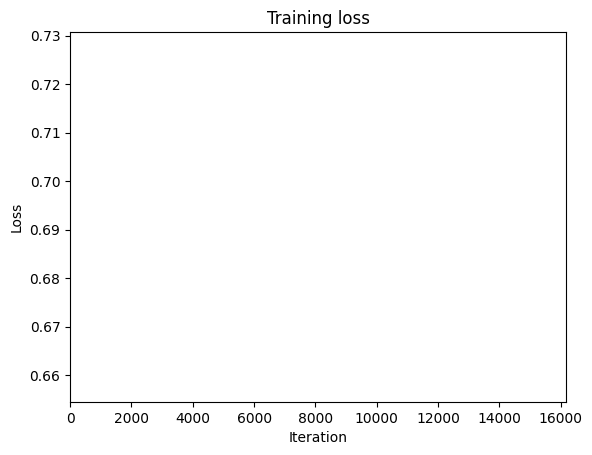

2it [00:00, 19.60it/s]

Epoch 0, loss 0.6926183700561523


994it [00:11, 89.02it/s]

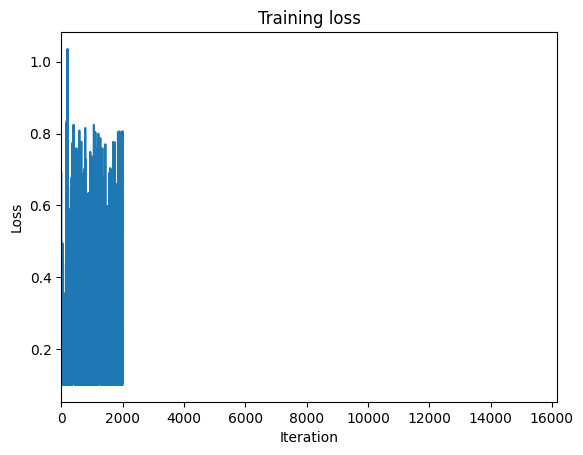

1011it [00:11, 87.32it/s]

Epoch 0, loss 0.27398196528851987


Epoch 0, validation loss 0.32718111877536915


0it [00:00, ?it/s]

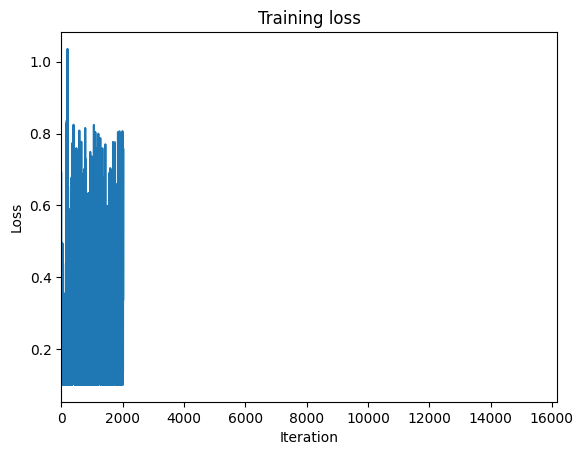

3it [00:00, 28.46it/s]

Epoch 1, loss 0.27700231231749056


993it [00:11, 87.40it/s]

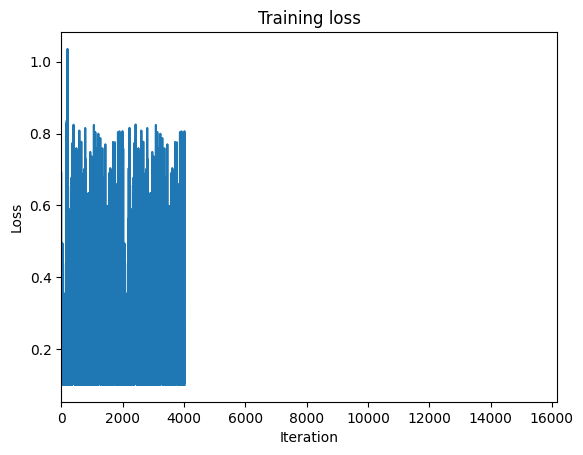

1011it [00:11, 86.89it/s]

Epoch 1, loss 0.27416380271315577


Epoch 1, validation loss 0.3271676312347194


0it [00:00, ?it/s]

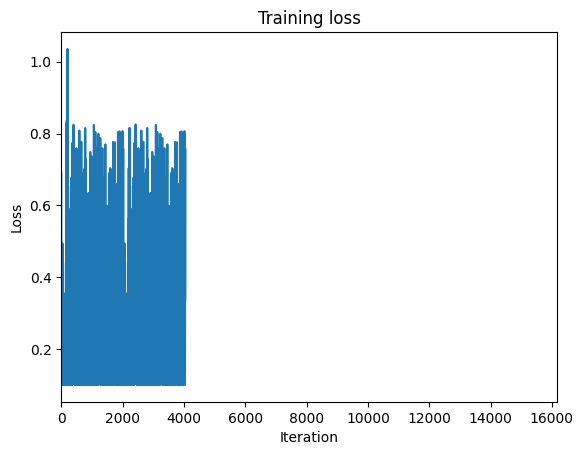

3it [00:00, 27.45it/s]

Epoch 2, loss 0.2771841499507427


993it [00:11, 88.88it/s]

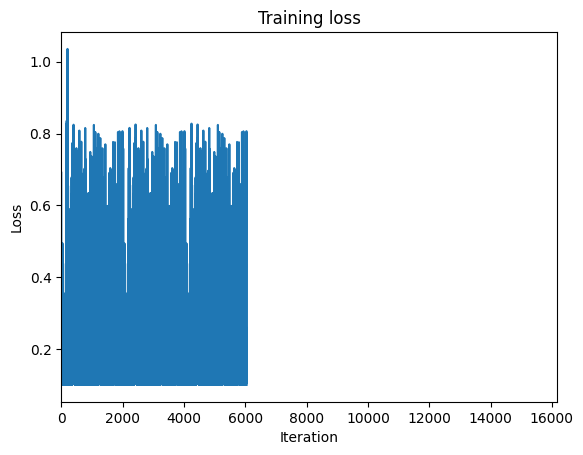

1011it [00:11, 87.14it/s]

Epoch 2, loss 0.27398578049242495


Epoch 2, validation loss 0.327120876431642


0it [00:00, ?it/s]

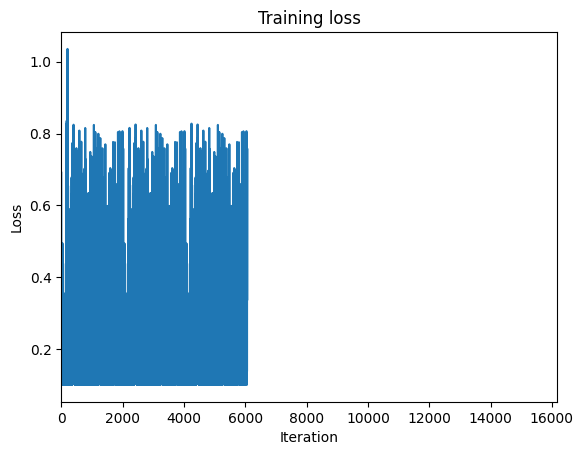

2it [00:00, 19.40it/s]

Epoch 3, loss 0.27700611199438574


992it [00:11, 87.02it/s]

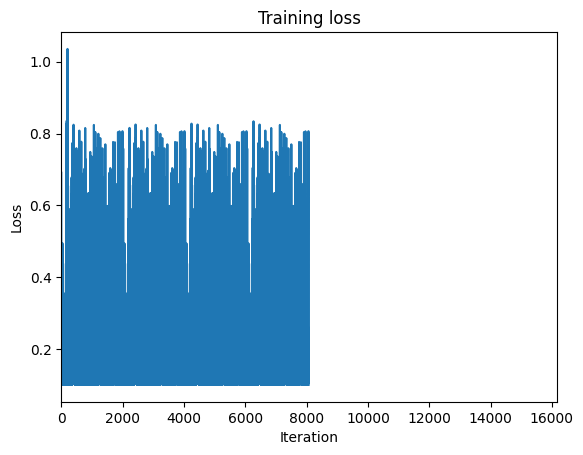

1011it [00:11, 86.44it/s]

Epoch 3, loss 0.2739686222821474


Epoch 3, validation loss 0.32698404755808125


0it [00:00, ?it/s]

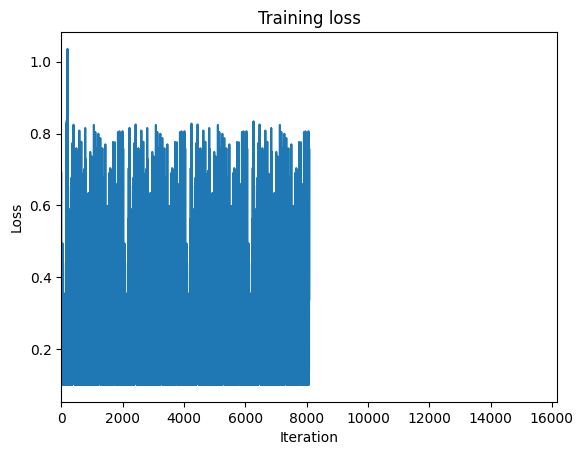

2it [00:00, 18.62it/s]

Epoch 4, loss 0.27698895286023617


992it [00:11, 86.93it/s]

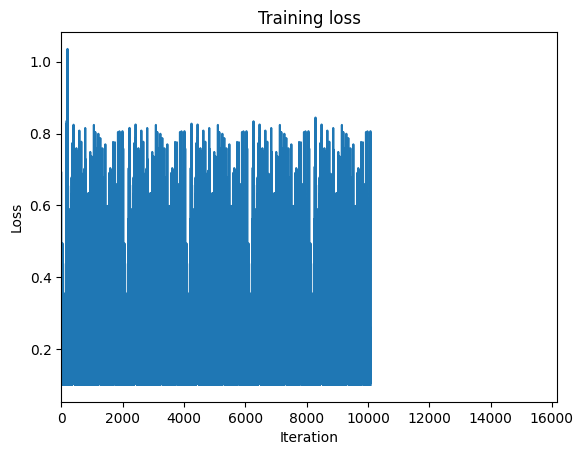

1011it [00:11, 85.15it/s]

Epoch 4, loss 0.273936892837286


Epoch 4, validation loss 0.3268140795190186


0it [00:00, ?it/s]

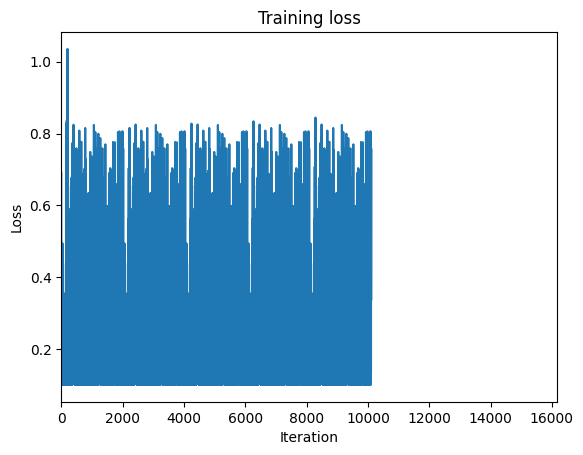

2it [00:00, 17.85it/s]

Epoch 5, loss 0.27695722311735155


992it [00:11, 87.19it/s]

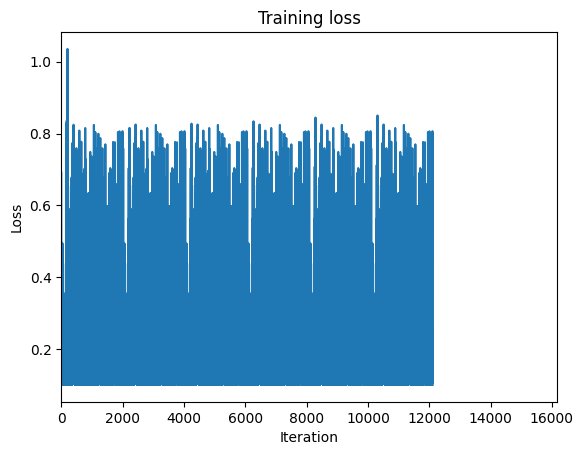

1011it [00:11, 85.05it/s]

Epoch 5, loss 0.2739018696844578


Epoch 5, validation loss 0.3267352422284797


0it [00:00, ?it/s]

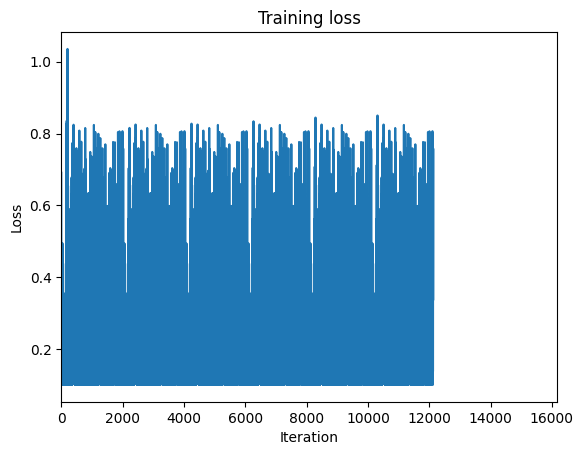

1it [00:00,  9.59it/s]

Epoch 6, loss 0.27692219960689546


1000it [00:11, 88.01it/s]

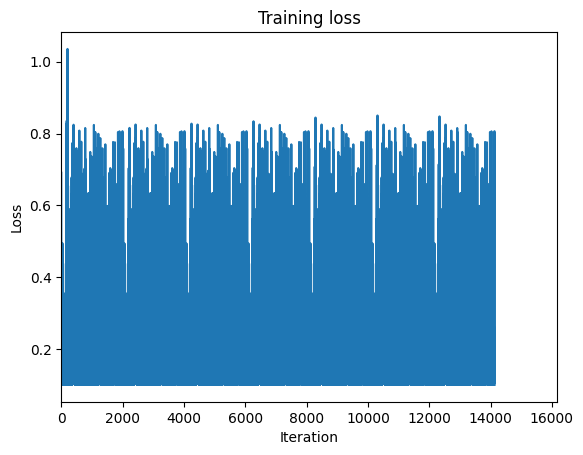

1011it [00:11, 85.67it/s]

Epoch 6, loss 0.2738692772388458


Epoch 6, validation loss 0.32672637391514875


0it [00:00, ?it/s]

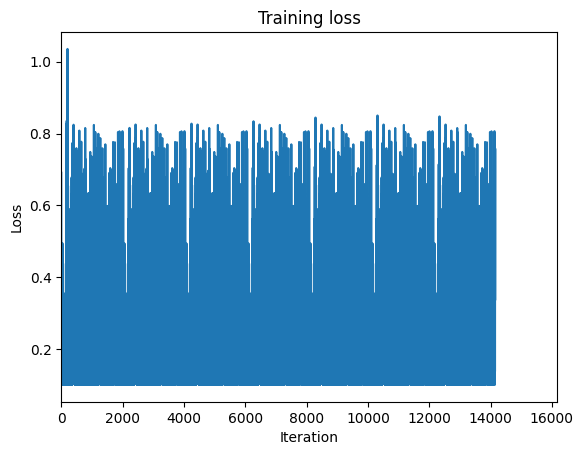

1it [00:00,  9.38it/s]

Epoch 7, loss 0.2768896069228649


1000it [00:11, 86.87it/s]

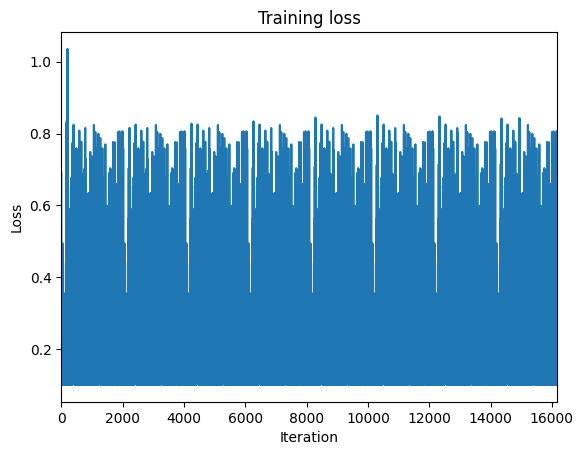

1011it [00:11, 85.42it/s]

Epoch 7, loss 0.27384341628849507


Epoch 7, validation loss 0.32672951469966144


In [28]:
# Run the training loop
g = torch.Generator(device='cpu')
g.manual_seed(12481)
hyperparameters = {'epochs': epochs, 'iters_per_dialog': iters_per_dialog, 'smooth_labels': True}
model = GCLWithHeadBert(character_embedding_dim, bert_dim, edge_dim, 1).to(torch_device)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-2)
criterion = SignedMSELoss()
scheduler = get_scheduler(optimizer)
character_embeddings = torch.rand((len(character_enum), character_embedding_dim), generator=g).to(torch_device)
losses, all_losses, val_losses = train_loop(model, optimizer, criterion, scheduler, character_embeddings, train_data, valid_data, hyperparameters)

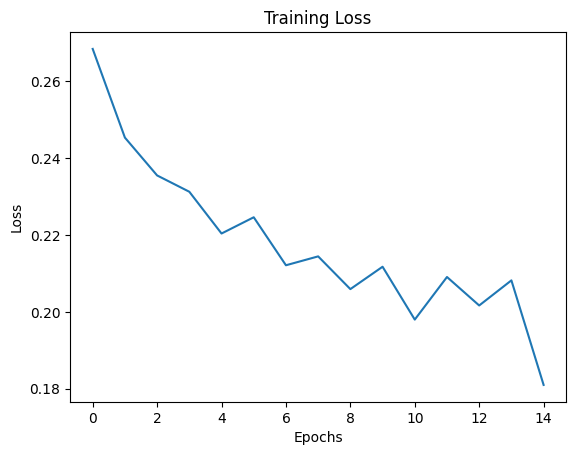

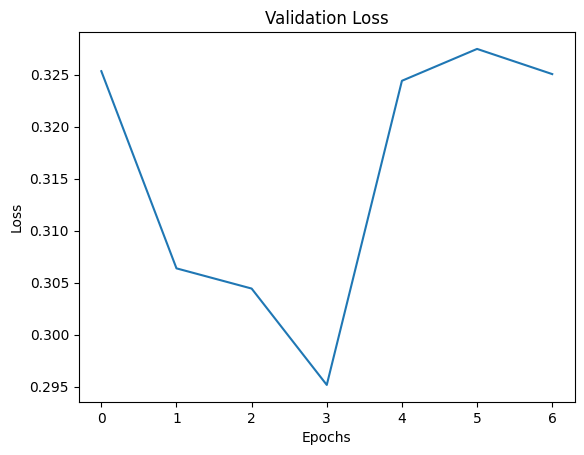

In [42]:
def get_avg_losses(loss, size):
    """
    For the list of losses, create a new list averaging together every size elements
    """
    avg_loss = []
    for i in range(0, len(loss), size):
        avg_loss.append(sum(loss[i:i+size])/size)
    return avg_loss[:-1]
  
avg_losses = get_avg_losses(all_losses, 1011)
plt.plot(range(len(avg_losses)), avg_losses)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

avg_val_losses = get_avg_losses(val_losses, 1)
plt.plot(range(len(avg_val_losses)), avg_val_losses)
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Evaluation Loop

In [36]:
def eval_loop(model, criterion, character_embeddings, test_data, verbose = True):
  correct, incorrect = 0, 0
  losses = []
  for index, row in tqdm.tqdm(test_data.iterrows()):
    dialog_gt = row['dialogue_sentiment']
    y = torch.tensor(dialog_gt).view(-1, 1).to(torch_device)
    
    # Forward pass: Compute predicted y by passing x to the model
    bert_value = get_bert_embedding(row)
    bert_row = np.array([float(val) for val in bert_value.strip('][').split(', ')])
    bert_embed = torch.from_numpy(bert_row).float().to(torch_device)
    speaker = torch.tensor([get_speaker(row)]).to(torch_device)
    listener = torch.tensor([get_listener(row)]).to(torch_device)

    with torch.no_grad():
      character_embeddings, y_pred = model(character_embeddings, bert_embed, speaker, 
                                            listener)
      
    # if y_pred and y are the same sign, increment correct, else increment incorrect
    if y_pred.item() * y.item() > 0:
      correct += 1
    else:
      incorrect += 1

    # Compute and print loss
    loss = criterion(y_pred, y)
    losses.append(loss.item())

  if verbose:
    # printing correctness/incorrect measured by direction
    print('accuracy', correct/(correct + incorrect))
  correctness = correct / (correct + incorrect)

  # printing accuracy based on loss
  loss_np = np.array(losses)
  accuracies = []
  for boundary in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    boolean = loss_np[loss_np <= boundary]
    if verbose:
      print(f"With error margin {boundary}, accuracy = {len(boolean) / len(loss_np)}")
    accuracies.append(len(boolean) / len(loss_np))
  if verbose:
    plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], accuracies, label='MSE Loss')
    plt.xlabel('Margin')
    plt.ylabel('Percent within Margin')
    plt.title('Loss Percent within Loss Margin')

  return losses, correctness, accuracies

In [ ]:
eval_loop(model, criterion, character_embeddings, test_data)

## Plotting Embeddings

In [55]:
# create a 2D plot of the vectors
def plot_2d(vectors, labels):
    tsne = TSNE(n_components=2, perplexity=1, random_state=0)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(vectors)
    labels = labels

    df = px.data.iris()
    fig = px.scatter(x=T[:,0], y=T[:,1], color=labels)
    fig.show()

In [56]:
plot_2d(char_embed, character_enum['character'])

/home/amks/ficembed/env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/amks/ficembed/env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



## Ablation Study for Architecutre

In [39]:
# Implement a model that accepts BERT embeddings as input, puts that through an MLP which outputs the scalar sentiment value which is returned
class BERTMLP(nn.Module):
    def __init__(self, bert_dim, output_dim):
        super().__init__()
        self.bert_dim = bert_dim
        self.output_dim = output_dim
        self.fc1 = nn.Linear(bert_dim, 16)
        self.fc2 = nn.Linear(16, output_dim)

    def forward(self, char_embed, bert_embed, speaker, listener):
        x = self.fc1(bert_embed)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        return None, x

In [46]:
# Hyperparams
bert_dim = 768
output_dim = 1
epochs = 20
iters_per_dialog = 1

Running training dialogues: 1011


0it [00:00, ?it/s]/home/amks/ficembed/env/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


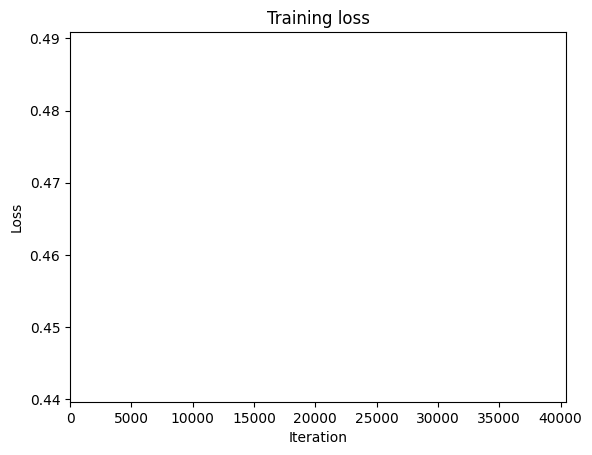

6it [00:00, 57.38it/s]

Epoch 0, loss 0.465271532535553


989it [00:04, 211.16it/s]

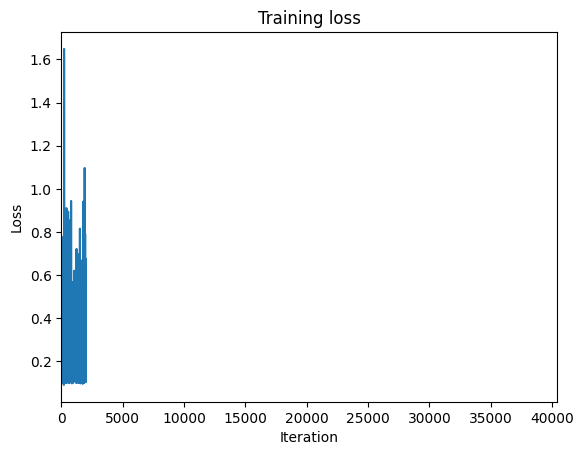

1011it [00:04, 205.90it/s]


Epoch 0, loss 0.26123920383304355
Epoch 0, validation loss 0.330097859399255


0it [00:00, ?it/s]

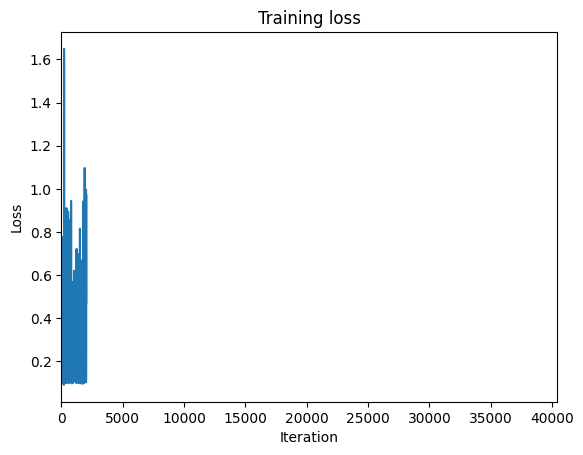

5it [00:00, 49.65it/s]

Epoch 1, loss 0.26597533861547706


992it [00:04, 213.06it/s]

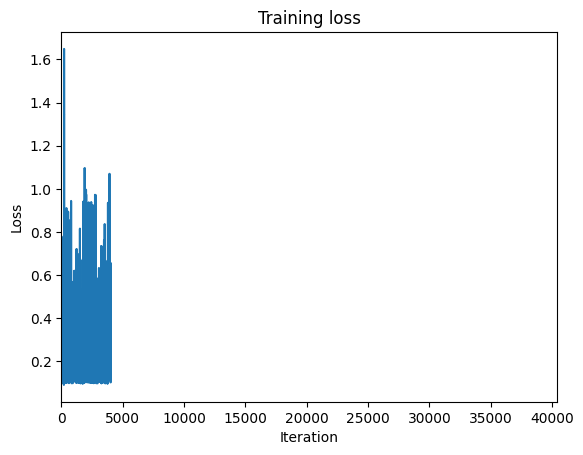

1011it [00:04, 205.47it/s]


Epoch 1, loss 0.25934828239679336
Epoch 1, validation loss 0.3285762059891967


0it [00:00, ?it/s]

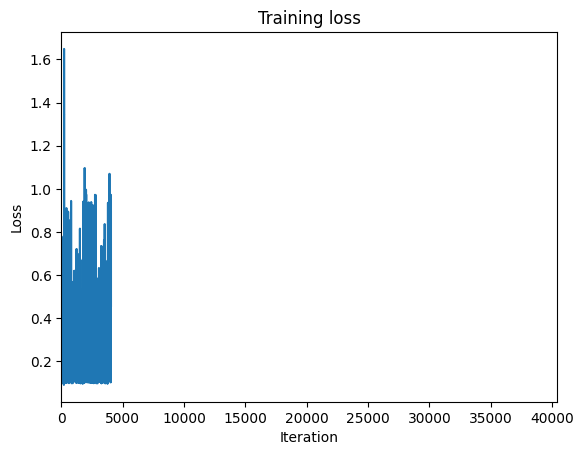

1it [00:00,  6.95it/s]

Epoch 2, loss 0.2639124097451568


998it [00:04, 208.34it/s]

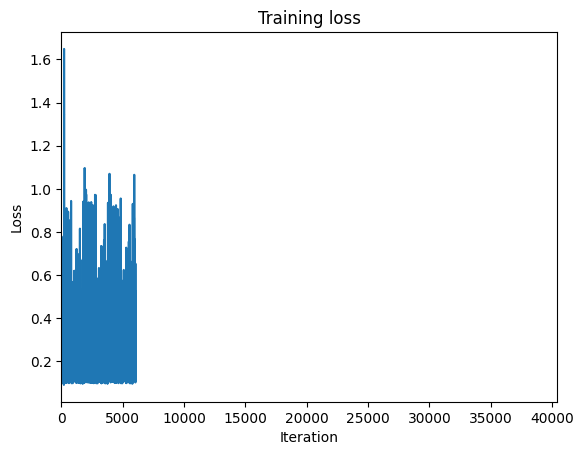

1011it [00:05, 199.78it/s]


Epoch 2, loss 0.25923522759974005
Epoch 2, validation loss 0.3283463230118907


0it [00:00, ?it/s]

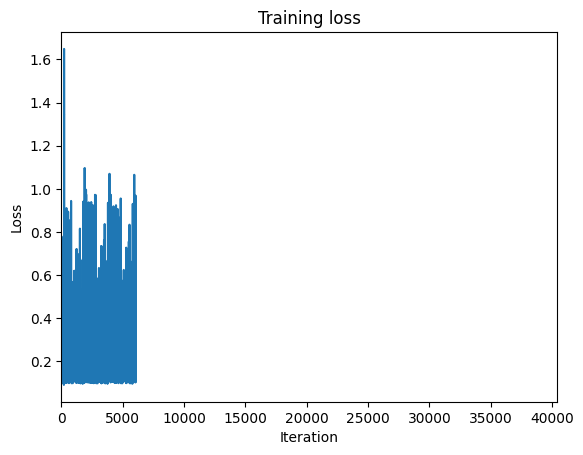

5it [00:00, 47.87it/s]

Epoch 3, loss 0.2637739626094699


988it [00:04, 212.76it/s]

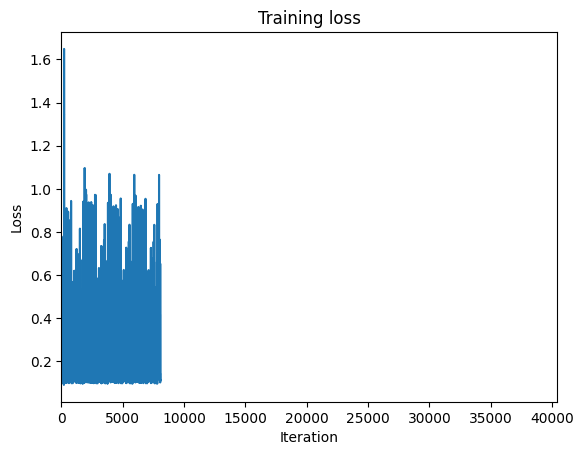

1011it [00:04, 203.56it/s]


Epoch 3, loss 0.2592390438169241
Epoch 3, validation loss 0.32832559677896583


0it [00:00, ?it/s]

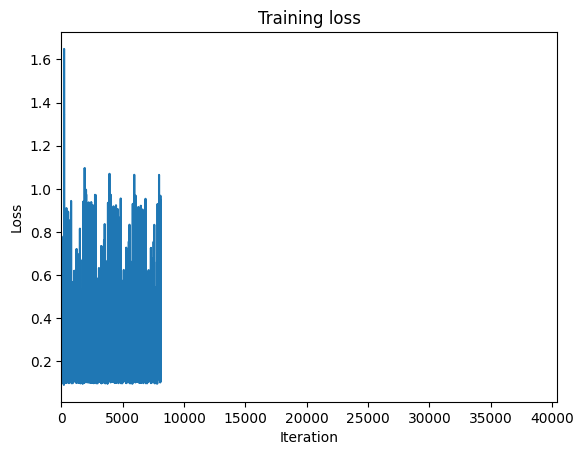

4it [00:00, 39.23it/s]

Epoch 4, loss 0.26377537815272806


983it [00:04, 208.57it/s]

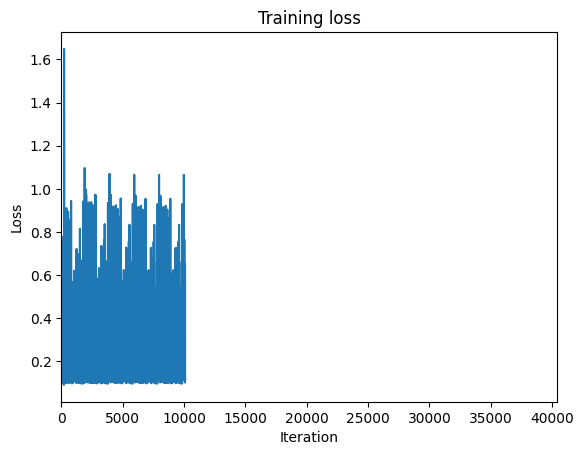

1011it [00:04, 202.51it/s]

Epoch 4, loss 0.2592746515870094


Epoch 4, validation loss 0.32831780864506166


0it [00:00, ?it/s]

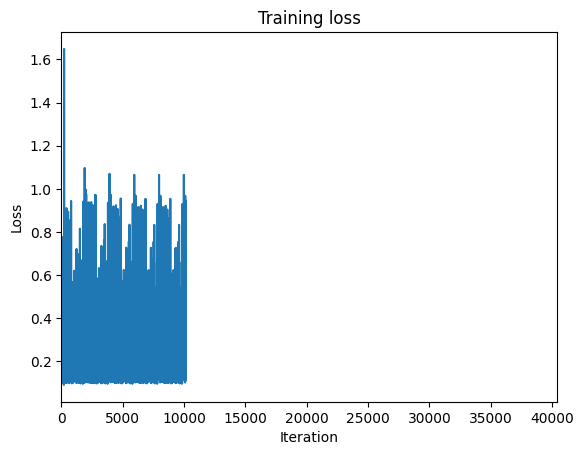

4it [00:00, 38.86it/s]

Epoch 5, loss 0.26381004113703965


979it [00:04, 211.17it/s]

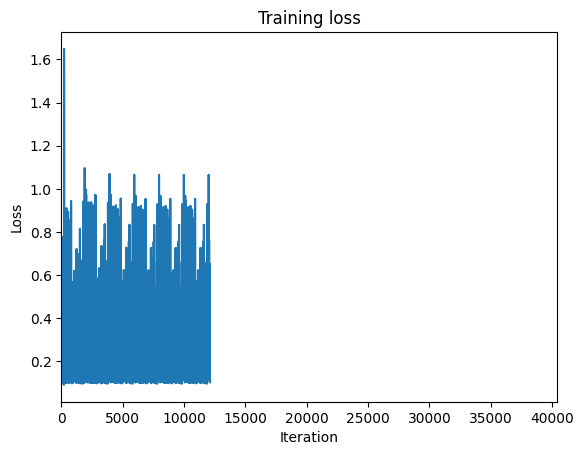

1011it [00:05, 201.84it/s]

Epoch 5, loss 0.25924414964020254


Epoch 5, validation loss 0.32832344420232124
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.


0it [00:00, ?it/s]

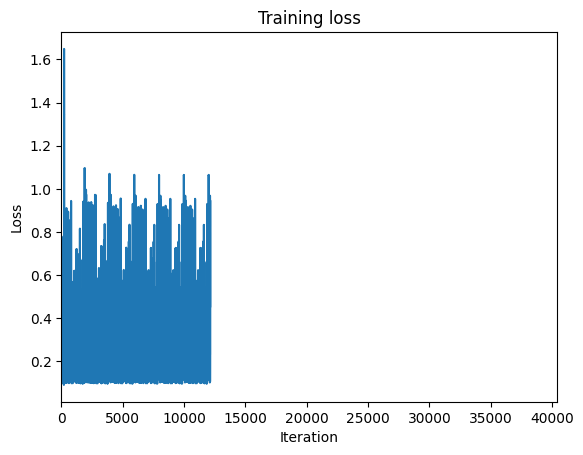

3it [00:00, 29.91it/s]

Epoch 6, loss 0.26378023682534696


1000it [00:04, 210.09it/s]

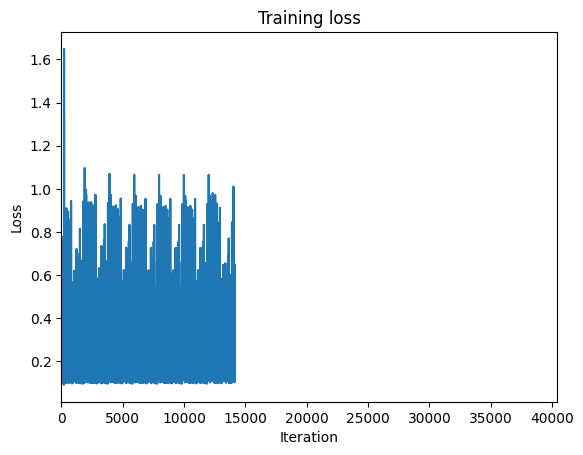

1011it [00:05, 201.39it/s]


Epoch 6, loss 0.2593352812677622
Epoch 6, validation loss 0.3286494333241743


0it [00:00, ?it/s]

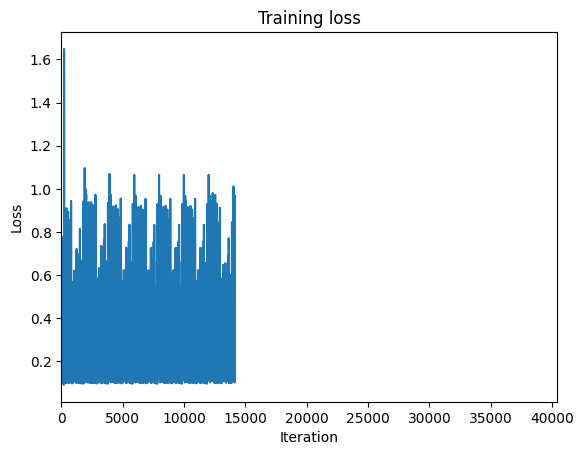

3it [00:00, 29.41it/s]

Epoch 7, loss 0.26388920079171657


998it [00:04, 210.66it/s]

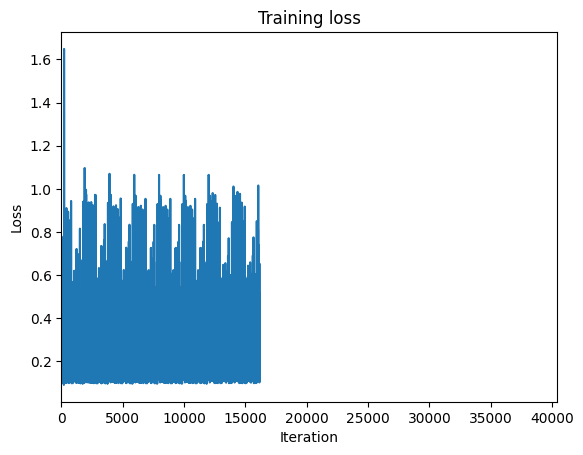

1011it [00:05, 201.12it/s]


Epoch 7, loss 0.2592620111852884
Epoch 7, validation loss 0.32892299476646175


0it [00:00, ?it/s]

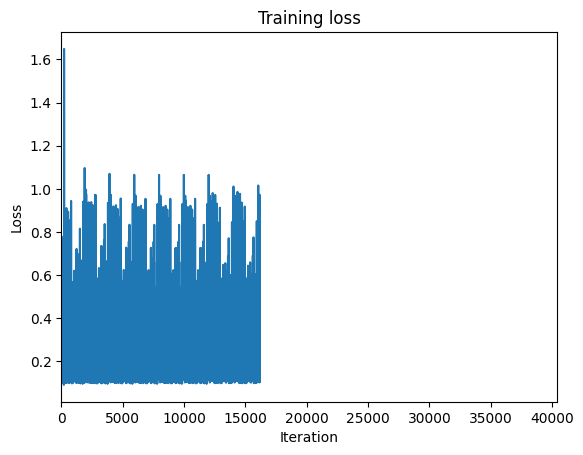

2it [00:00, 19.68it/s]

Epoch 8, loss 0.2638489212319255


982it [00:04, 209.51it/s]

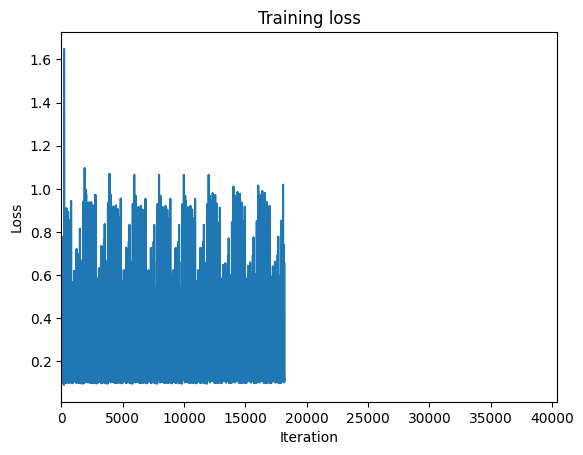

1011it [00:05, 201.67it/s]

Epoch 8, loss 0.2592114096879959


Epoch 8, validation loss 0.32914976439596283
Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.


0it [00:00, ?it/s]

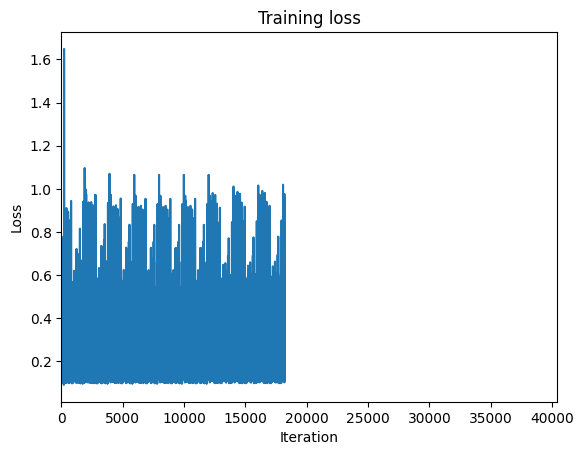

2it [00:00, 19.62it/s]

Epoch 9, loss 0.26382474789768456


985it [00:04, 211.19it/s]

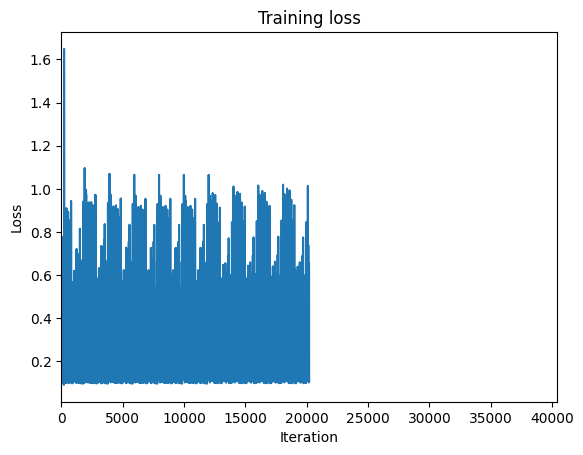

1011it [00:05, 201.75it/s]

Epoch 9, loss 0.2591162359267473


Epoch 9, validation loss 0.3291700096353225


0it [00:00, ?it/s]

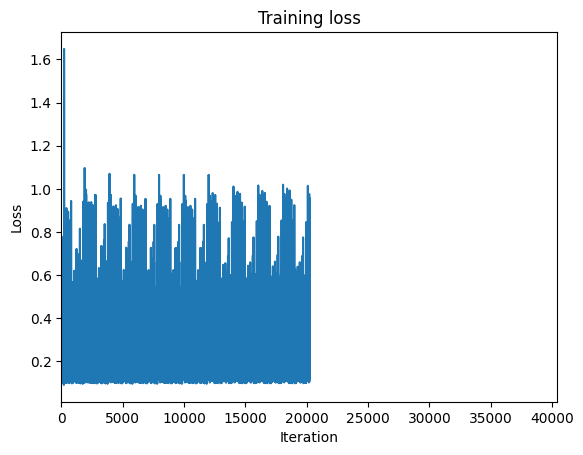

1it [00:00,  6.16it/s]

Epoch 10, loss 0.26373087502270937


986it [00:04, 213.96it/s]

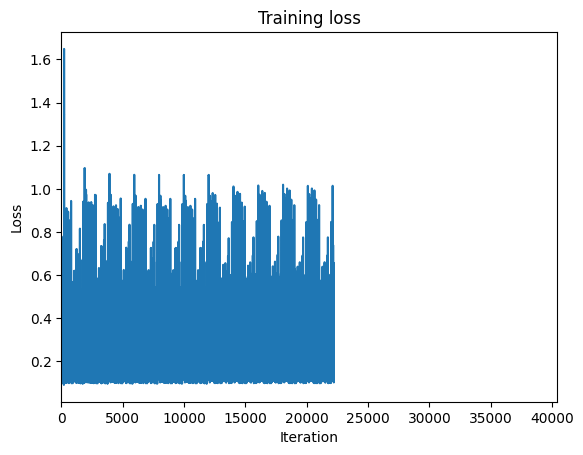

1011it [00:05, 200.52it/s]

Epoch 10, loss 0.2591125425845385


Epoch 10, validation loss 0.3291898621384397


0it [00:00, ?it/s]

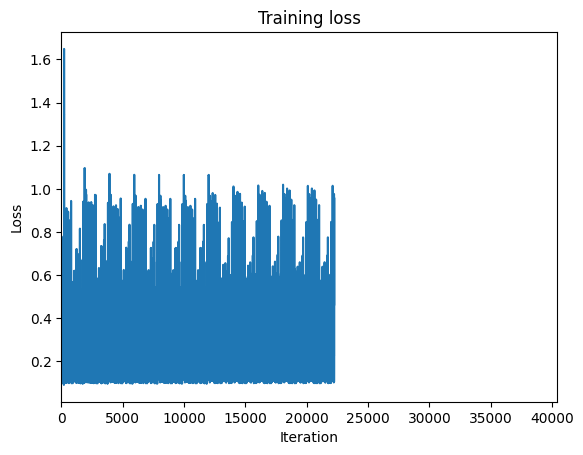

1it [00:00,  9.68it/s]

Epoch 11, loss 0.26372943437099455


995it [00:04, 206.12it/s]

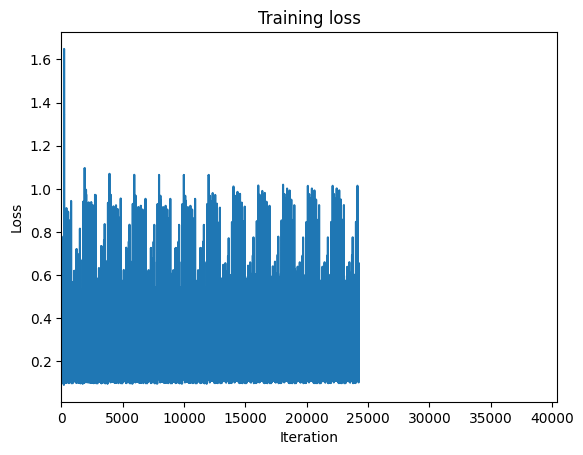

1011it [00:05, 200.30it/s]


Epoch 11, loss 0.25910898838937285
Epoch 11, validation loss 0.32920935931297723
Epoch 00012: reducing learning rate of group 0 to 1.0000e-06.


0it [00:00, ?it/s]

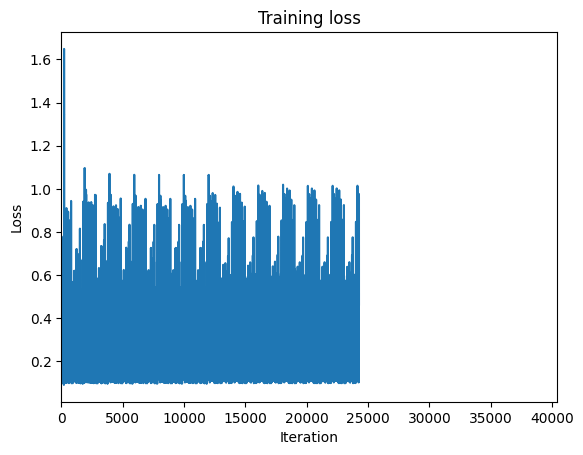

1it [00:00,  9.04it/s]

Epoch 12, loss 0.2637280859425664


981it [00:04, 211.23it/s]

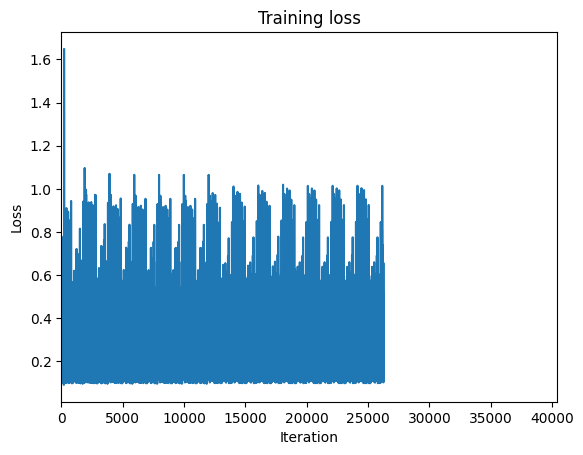

1011it [00:05, 201.03it/s]

Epoch 12, loss 0.2590985449030995


Epoch 12, validation loss 0.32921127977197884


0it [00:00, ?it/s]

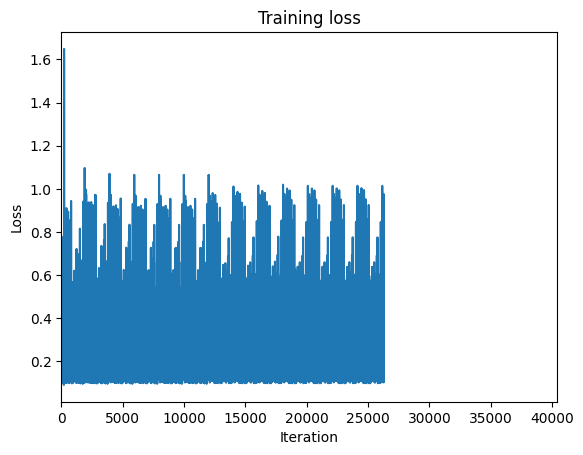

1it [00:00,  9.22it/s]

Epoch 13, loss 0.2637177652791142


1000it [00:04, 207.66it/s]

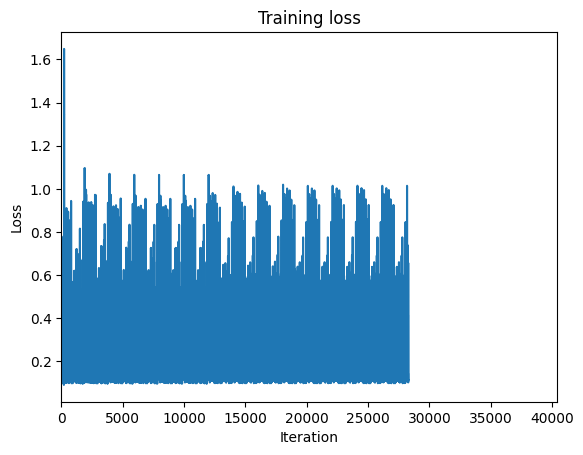

1011it [00:05, 200.81it/s]


Epoch 13, loss 0.25909820091724395
Epoch 13, validation loss 0.3292132019996643


0it [00:00, ?it/s]

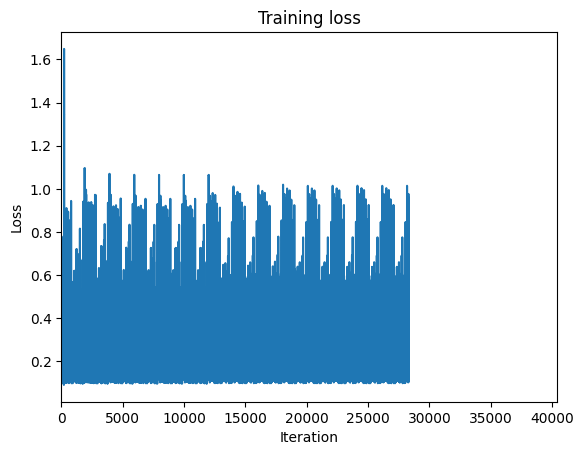

1it [00:00,  8.13it/s]

Epoch 14, loss 0.2637176381200552


981it [00:04, 212.18it/s]

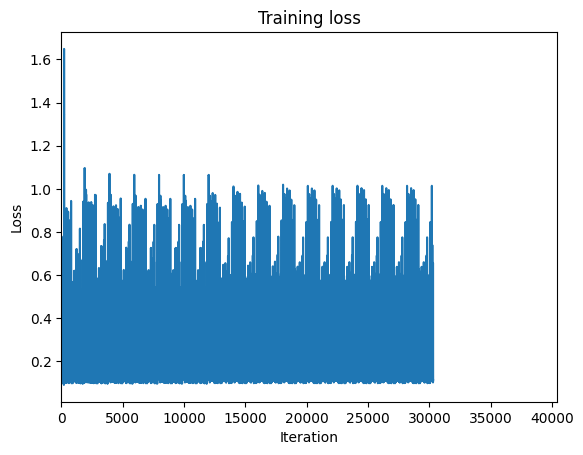

1011it [00:05, 200.67it/s]

Epoch 14, loss 0.2590978576242924


Epoch 14, validation loss 0.3292151151186281
Epoch 00015: reducing learning rate of group 0 to 1.0000e-07.


0it [00:00, ?it/s]

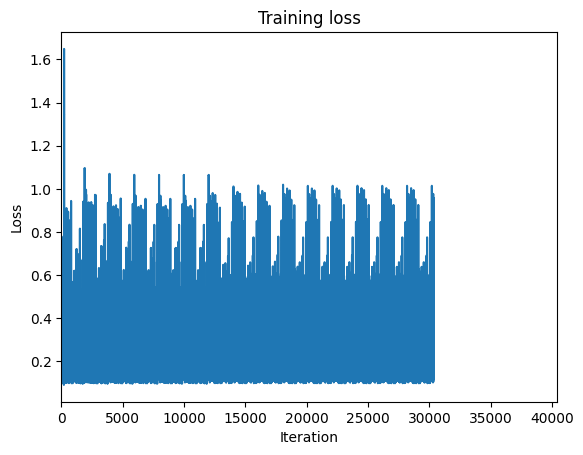

1it [00:00,  8.11it/s]

Epoch 15, loss 0.26371751075237987


980it [00:04, 210.30it/s]

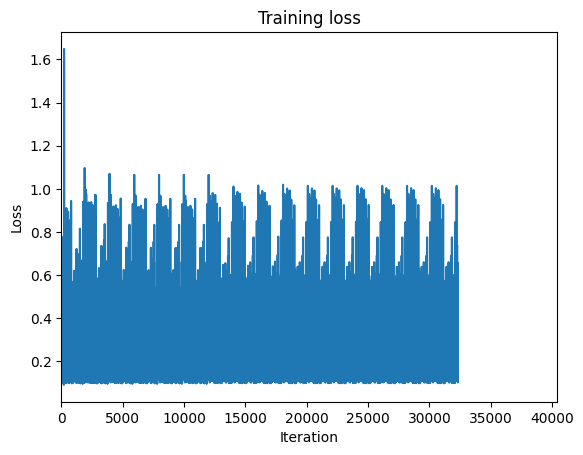

1011it [00:05, 200.17it/s]

Epoch 15, loss 0.25909680603444574


Epoch 15, validation loss 0.3292153100275852


0it [00:00, ?it/s]

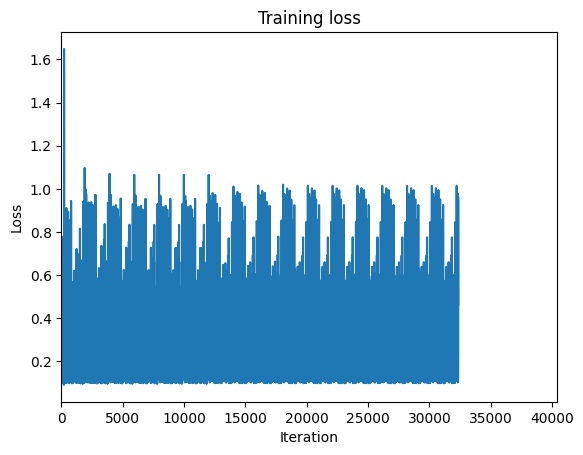

1it [00:00,  8.15it/s]

Epoch 16, loss 0.2637164718955755


981it [00:04, 210.40it/s]

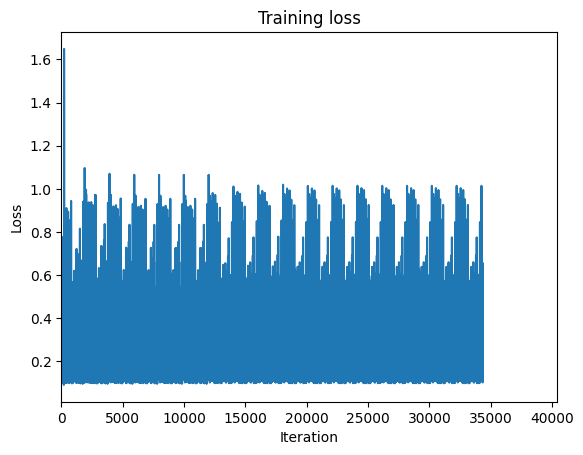

1011it [00:05, 199.92it/s]

Epoch 16, loss 0.2590967706888914


Epoch 16, validation loss 0.3292155045828055


0it [00:00, ?it/s]

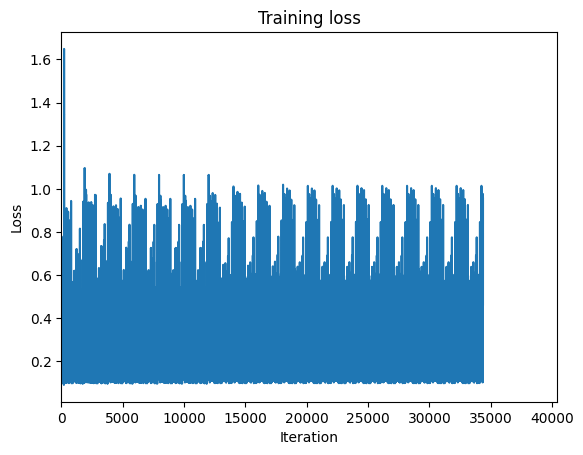

1it [00:00,  8.07it/s]

Epoch 17, loss 0.263716457888484


1000it [00:04, 210.69it/s]

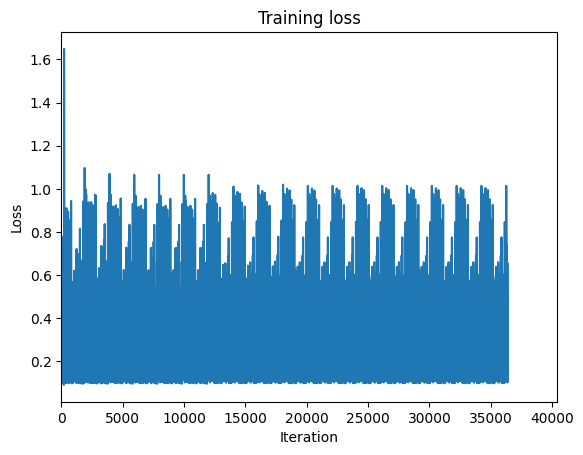

1011it [00:05, 199.10it/s]


Epoch 17, loss 0.2590967361778021
Epoch 17, validation loss 0.32921569201907347
Epoch 00018: reducing learning rate of group 0 to 1.0000e-08.


0it [00:00, ?it/s]

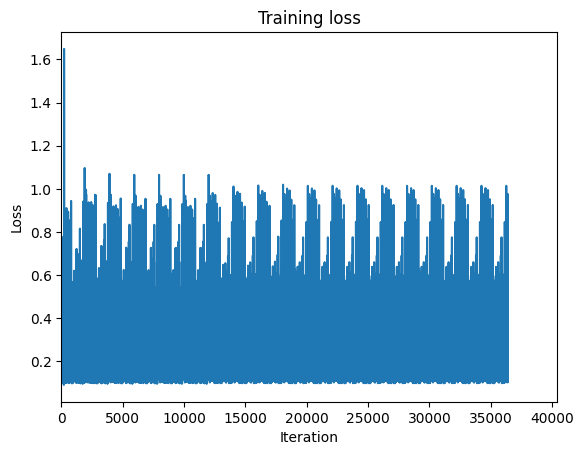

1it [00:00,  7.93it/s]

Epoch 18, loss 0.2637164452597499


994it [00:04, 206.68it/s]

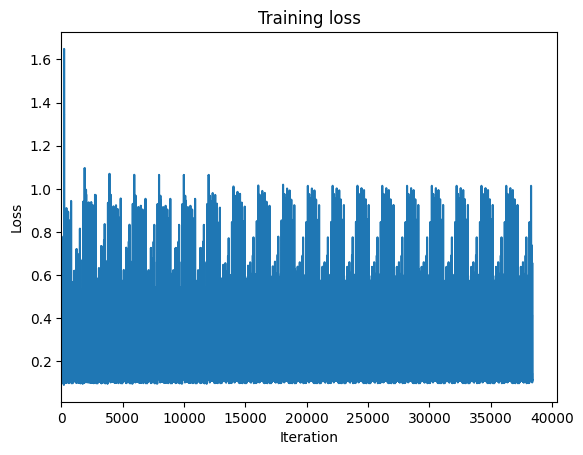

1011it [00:05, 195.66it/s]

Epoch 18, loss 0.2590966258198023


Epoch 18, validation loss 0.32921568631506815


0it [00:00, ?it/s]

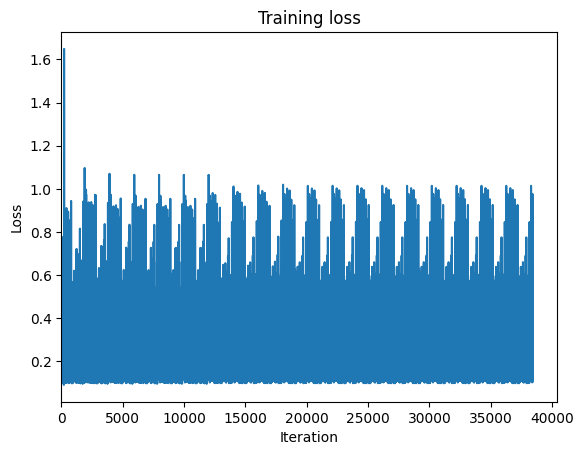

1it [00:00,  8.07it/s]

Epoch 19, loss 0.26371633284538987


986it [00:04, 210.69it/s]

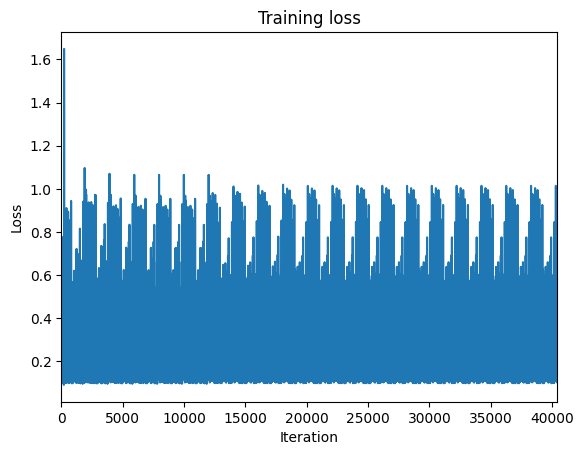

1011it [00:05, 194.16it/s]

Epoch 19, loss 0.2590966287404299


Epoch 19, validation loss 0.3292156762777875


In [47]:
# RUn the training loop
g = torch.Generator(device='cpu')
g.manual_seed(12481)
hyperparameters = {'epochs': epochs, 'iters_per_dialog': iters_per_dialog, 'smooth_labels': True}
model = BERTMLP(bert_dim, output_dim).to(torch_device)
optimizer = torch.optim.Adam(model.parameters())
criterion = SignedMSELoss()
scheduler = get_scheduler(optimizer)
losses, all_losses, val_losses = train_loop(model, optimizer, criterion, scheduler, None, train_data, valid_data, hyperparameters)

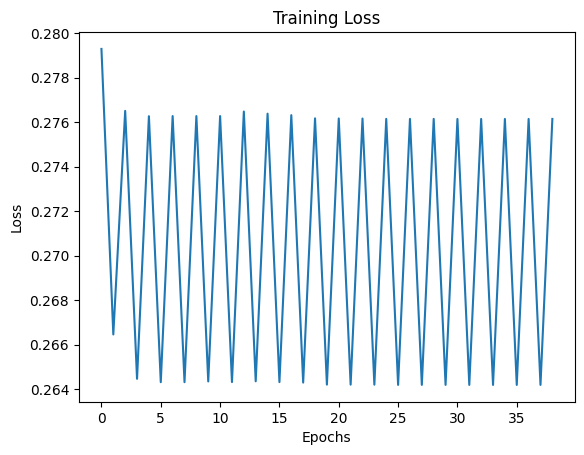

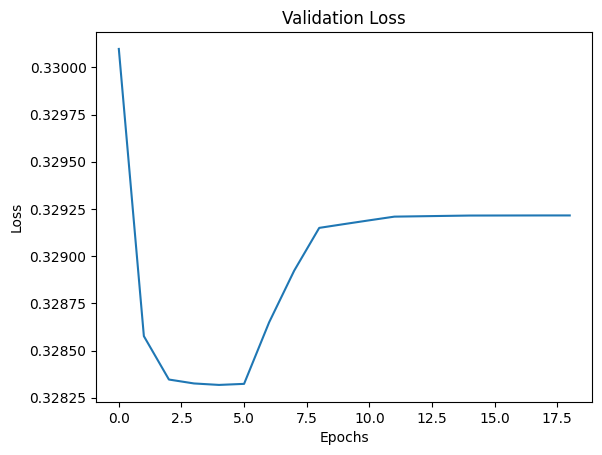

In [48]:
# Print the average training loss
avg_losses = get_avg_losses(all_losses, 1011)
plt.plot(range(len(avg_losses)), avg_losses)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Print the average validation loss
avg_val_losses = get_avg_losses(val_losses, 1)
plt.plot(range(len(avg_val_losses)), avg_val_losses)
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

338it [00:00, 1383.12it/s]

accuracy 0.6301775147928994
With error margin 0.1, accuracy = 0.011834319526627219
With error margin 0.2, accuracy = 0.5
With error margin 0.3, accuracy = 0.5769230769230769
With error margin 0.4, accuracy = 0.6952662721893491
With error margin 0.5, accuracy = 0.7485207100591716
With error margin 0.6, accuracy = 0.8136094674556213
With error margin 0.7, accuracy = 0.8550295857988166
With error margin 0.8, accuracy = 0.8727810650887574
With error margin 0.9, accuracy = 0.9230769230769231
With error margin 1, accuracy = 0.9822485207100592


([0.1120704710483551,
  0.1120704710483551,
  0.1120704710483551,
  0.34600022435188293,
  0.34600022435188293,
  0.2190386801958084,
  0.2190386801958084,
  0.1120704710483551,
  0.1120704710483551,
  0.1120704710483551,
  0.1120704710483551,
  0.1120704710483551,
  0.1120704710483551,
  0.38068658113479614,
  0.38068658113479614,
  0.36038753390312195,
  0.36038753390312195,
  0.2816212773323059,
  0.2816212773323059,
  0.1120704710483551,
  0.1120704710483551,
  0.1120704710483551,
  0.1120704710483551,
  0.1120704710483551,
  0.1120704710483551,
  0.5192829370498657,
  0.5192829370498657,
  0.538548469543457,
  0.538548469543457,
  0.17981067299842834,
  0.17981067299842834,
  0.20022279024124146,
  0.20022279024124146,
  0.16622385382652283,
  0.16622385382652283,
  0.6647726893424988,
  0.6647726893424988,
  0.1120704710483551,
  0.1120704710483551,
  0.1120704710483551,
  0.1120704710483551,
  0.14213602244853973,
  0.14213602244853973,
  0.14936961233615875,
  0.149369612336158

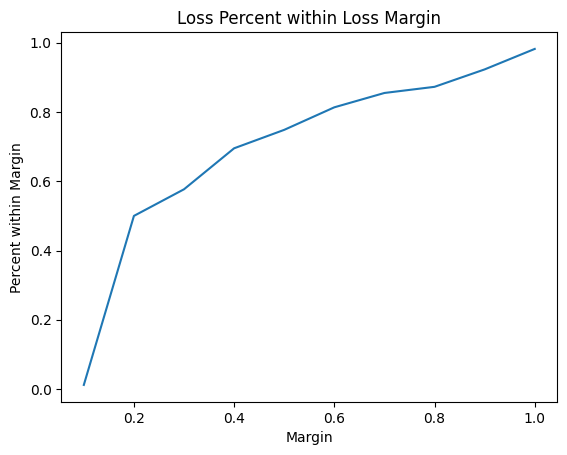

In [49]:
# Run the eval
eval_loop(model, criterion, None, test_data)

## HyperParameter Search

In [ ]:
# Set up hyperparameter for grid search
character_embedding_dims = [4, 8, 16, 32, 64, 128]
bert_dims = [768]
edge_dims = [2, 4, 8, 16, 32, 64, 128]
epochs = [1]
iters_per_dialog = [1]

In [ ]:
# save data here
data = {}

In [ ]:
# Save data to file as checkpoint
with open('grid_search_data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
# Perform grid search
g = torch.Generator()
g.manual_seed(42)
for character_embedding_dim in character_embedding_dims:
    for bert_dim in bert_dims:
        for edge_dim in edge_dims:
            for epoch_count in epochs:
                for iters_count in iters_per_dialog:
                    print('Testing: ', character_embedding_dim, bert_dim, edge_dim, epoch_count, iters_count)
                    # Run the training loop
                    hyperparameters = {'epochs': epoch_count, 'iters_per_dialog': iters_count}
                    model = GCLWithHeadBert(character_embedding_dim, bert_dim, edge_dim, 1).to(torch_device)
                    optimizer = torch.optim.Adam(model.parameters())
                    criterion = SignedMSELoss()
                    scheduler = get_scheduler(optimizer)
                    character_embeddings = torch.rand((len(character_enum), character_embedding_dim), generator=g).to(torch_device)
                    losses, all_losses, val_losses = train_loop(model, optimizer, criterion, scheduler, character_embeddings, train_data, valid_data, hyperparameters, print_every=10000)
                    losses_eval, correctness, accuracies = eval_loop(model, criterion, character_embeddings, test_data, verbose=False)
                    # save data here
                    data[(character_embedding_dim, bert_dim, edge_dim, epoch_count, iters_count)] = (losses, all_losses, val_losses, losses_eval, correctness, accuracies)
    
    # Save data to file as checkpoint
    with open('grid_search_data.pkl', 'wb') as f:
        pickle.dump(data, f)


In [ ]:
# Plot the following: Average loss value against values of edge_dim
# (losses, all_losses, val_losses, losses_eval, correctness, accuracies)
losses = []
losses2 = []
accuracies = []
accuracies2 = []
for edge_dim in edge_dims:
    avg_losses = get_avg_losses(data[(16, 768, edge_dim, 1, 1)][1], 1011)
    accuracies.append(data[(16, 768, edge_dim, 1, 1)][5][1])
    losses.append(avg_losses[-1])

for char_dim in character_embedding_dims:
    avg_losses = get_avg_losses(data[(char_dim, 768, 16, 1, 1)][1], 1011)
    accuracies2.append(data[(char_dim, 768, 16, 1, 1)][5][1])
    losses2.append(avg_losses[-1])

# Create four subplots 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(5, 5))
# Add space between plots
fig.tight_layout(pad=5.0)
# Decrease font size
plt.rcParams.update({'font.size': 8})
ax1.plot(edge_dims, accuracies)
ax1.set_title('Accuracy vs. Edge Dimension')
ax1.set_xlabel('Edge Dimension')
ax1.set_ylabel('Accuracy')
ax2.plot(edge_dims, losses)
ax2.set_title('Loss vs. Edge Dimension')
ax2.set_xlabel('Edge Dimension')
ax2.set_ylabel('Loss')
ax3.plot(character_embedding_dims, accuracies2)
ax3.set_title('Accuracy vs. Char Embed Dim')
ax3.set_xlabel('Character Embedding Dimension')
ax3.set_ylabel('Accuracy')
ax4.plot(character_embedding_dims, losses2)
ax4.set_title('Loss vs. Char Embed Dim')
ax4.set_xlabel('Character Embedding Dimension')
ax4.set_ylabel('Loss')
plt.show()


## Manual Testing

In [ ]:
character_translation = {index: name for index, name in enumerate(character_enum['character'])}
juliet_side = ["JULIET", "NURSE", "LADY CAPULET", "CAPULET"]
romeo_side = ["ROMEO", "FRIAR LAWRENCE", "FRIAR JOHN", "BALTHASAR", "MERCUTIO", "BENVOLIO", "MONTAGUE"]
evil_side = ["TYBALT", "PARIS", "PRINCE", "APOTHECARY"]

name_to_index = {v:k for k,v in character_translation.items()}
juliet_indices = [name_to_index[name] for name in juliet_side]
romeo_indices = [name_to_index[name] for name in romeo_side]
evil_indices = [name_to_index[name] for name in evil_side]

juliet_friends = [character_embeddings[index].detach().cpu().numpy() for index in juliet_indices]
romeo_friends = [character_embeddings[index].detach().cpu().numpy() for index in romeo_indices]
evil_friends = [character_embeddings[index].detach().cpu().numpy() for index in evil_indices]

juliet = juliet_friends[0]
romeo = romeo_friends[0]

juliet_distances = [np.linalg.norm(juliet - friend) for friend in juliet_friends]
romeo_distances = [np.linalg.norm(romeo - friend) for friend in romeo_friends]

juliet_romeo_distances = [np.linalg.norm(juliet - other) for other in romeo_friends]
juliet_evil_distances = [np.linalg.norm(juliet - other) for other in evil_friends]

romeo_juliet_distances = [np.linalg.norm(romeo - other) for other in juliet_friends]
romeo_evil_distances = [np.linalg.norm(romeo - other) for other in evil_friends]

print(np.mean(juliet_distances), np.mean(juliet_romeo_distances), np.mean(juliet_evil_distances))
print(np.mean(romeo_distances), np.mean(romeo_juliet_distances), np.mean(romeo_evil_distances))